In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv


In [6]:
def icp():
    
    return 

def correspondences(w, E, D, G):
    # w weights (pixel)
    # E edges binary
    # D distances
    # G gradient
    pass
    
    
def compute_E(img):
    E = cv.Canny(img, 120, 120)
    return E

def compute_D(edges_binary):
    # computes distances from 0 values
    E_invert = cv.bitwise_not(edges_binary)
    D = cv.distanceTransform(E_invert.astype(np.uint8), distanceType=cv.DIST_L2, maskSize=0)
    return D

def compute_G(distances):
    # compute gradient from distances
    kernel = np.array([-1, 0, 1])
    grad_x = cv.filter2D(distances, ddepth=-1, kernel=kernel)
    grad_y = cv.filter2D(distances, ddepth=-1, kernel=kernel.T)

    return grad_x, grad_y

TypeError: Invalid shape (2, 600, 800) for image data

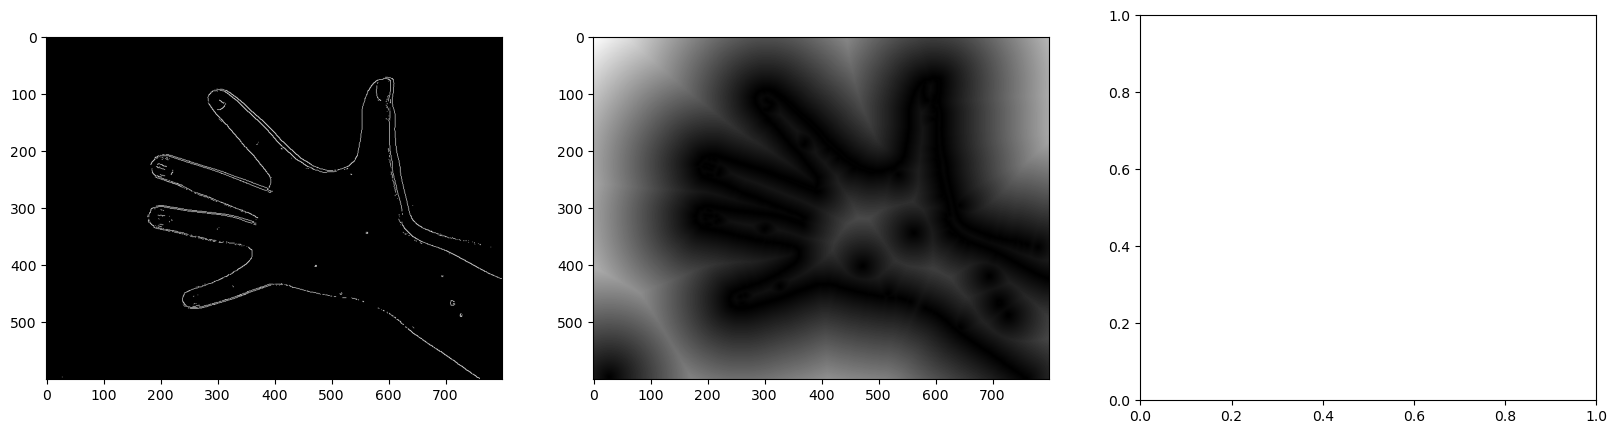

In [7]:
# hand_landmarks.txt adjusted because of stange format of the landmarsk for np textload
hand_landmarks = np.loadtxt("data/hand_landmarks.txt")
hand_img = cv.imread("./data/hand.jpg")

E = compute_E(hand_img)
D = compute_D(E)
G = compute_G(D)

_, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].imshow(E, cmap="gray")
ax[1].imshow(D, cmap="gray")
ax[1].imshow(G, cmap="gray")

icp()